In [1]:
%pylab inline
#Autoreload so changing py files works
%load_ext autoreload
%autoreload 2
import gc, os, math, random

import numpy as np
from IPython.display import Image, display, clear_output
from matplotlib import pyplot as plt
import cv2
import time

#Only if you're using theano
#import theano
#theano.gpuarray.use('cuda')

backend = 'tensorflow'
os.environ['KERAS_BACKEND'] = backend
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from Util import *

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
#LOAD VIDEO
frame_size = (128, 128)
chair = loadVideoFrames('Chair.mp4', max_frames=-1, resize=frame_size)

Loaded in: 6.6033775806427


In [3]:
#CREATE NETWORK

if backend == 'tensorflow':
    K.clear_session()

auto_encoder_opt = Adam(lr=0.0002)

encoder_input_size = frame_size + (3,)
size_flattened = encoder_input_size[0] * encoder_input_size[1] * encoder_input_size[2]

alpha = 0.2
momentum = 0.8

encoder_size = 3000

encoder_input = Input(shape=encoder_input_size)

def convLayer(x, res, kernel_size=1, strides=1, padding='valid', momentum=0.8, alpha=0.2):
    x = Conv2D(res, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha)(x)
    return x

def deConvLayer(x, res, kernel_size=1, strides=1, padding='valid', momentum=0.8, alpha=0.2):
    x = Conv2DTranspose(res, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = ReLU()(x)
    return x

x = convLayer(encoder_input, 32, kernel_size=6, strides=2)
x = convLayer(x, 64, kernel_size=6, strides=2)

x = deConvLayer(x, 64, kernel_size=6, strides=2)
decoder_output = deConvLayer(x, 3, kernel_size=6, strides=2)


auto_encoder = Model(encoder_input, decoder_output)
auto_encoder.compile(loss='mean_squared_error', optimizer=auto_encoder_opt)
auto_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        3488      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 29, 29, 64)        0         
__________

In [4]:
from NetHistory import NetHistory
X_train = np.array(chair)
history = NetHistory()

In [5]:
from keras.models import load_model
auto_encoder = load_model('Auto_Encoder.h5')

In [6]:
#TRAINING
auto_encoder.fit(X_train, X_train, batch_size=32, epochs=5, validation_split=0.8, callbacks=[history])

Train on 268 samples, validate on 1075 samples
Epoch 1/5
268/268 [==============================] - 4s 16ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 2/5
268/268 [==============================] - 3s 11ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 3/5
268/268 [==============================] - 3s 10ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 4/5
268/268 [==============================] - 3s 10ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/5
268/268 [==============================] - 3s 10ms/step - loss: 0.0017 - val_loss: 0.0023


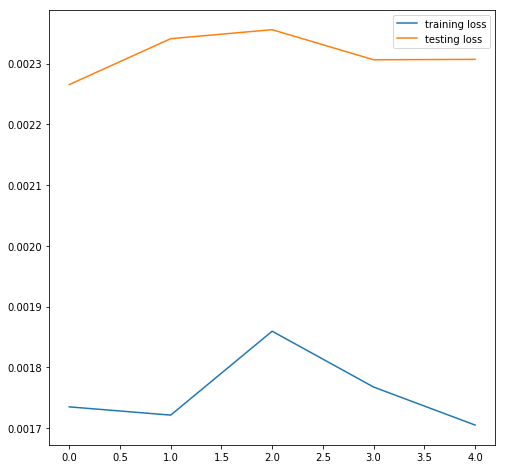

In [7]:
history.showLoss()

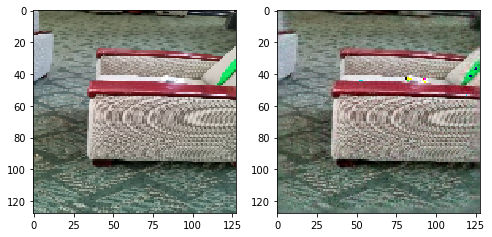

In [9]:
showPredictions(auto_encoder, X_train[100:101])

In [ ]:
#auto_encoder.save('Auto_Encoder.h5')